In [99]:
suppressMessages(library(data.table))
suppressMessages(library(magrittr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(dplyr))
suppressMessages(library(IsoformSwitchAnalyzeR))

In [2]:
setwd("/Users/inamojun/TMDU-LR_isoform_atlas/Figures")

In [3]:
# All datasets to perform IsoformSwitchAnalyzeR
data.frame(disease = c("SLE",
                               "SSc",
                               "pSS",
                               "RA",
                               # "RA",
                               # "RA",
                               # "RA",
                               "RA",
                               "RA",
                               "RA",
                               "RA",
                               "RA",
                               "COVID19",
                               # "COVID19",
                               "COVID19",
                               "influenza virus"),
                   comparison = c("vs Healthy",
                                  "vs Healthy",
                                  "vs Healthy",
                                  "Healthy vs Arthralgia vs Osteoarthritis vs Undifferentiated arthritis vs Rheumatoid arthritis (early) vs Rheumatoid arthritis (established)",
                                  # "Healthy vs Rheumatoid arthritis (early)",
                                  # "Healthy vs Rheumatoid arthritis (established)",
                                  # "Rheumatoid arthritis (early) vs Rheumatoid arthritis (established)",
                                  "Fibroid vs Lymphoid vs Myeloid [synovium]",
                                  "Fibroid vs Lymphoid vs Myeloid [blood]",
                                  "Synovium vs Blood [Fibroid]",
                                  "Synovium vs Blood [Lymphoid]",
                                  "Synovium vs Blood [Myeloid]",
                                  "vs Healthy",
                                  # "mild vs moderate vs serious",
                                  "vs Healthy",
                                  "vs Healthy"
                   ),
                   GEO_id = c("GSE72509",
                              "GSE130955",
                              "GSE145065",
                              "GSE89408",
                              # "GSE89408",
                              # "GSE89408",
                              # "GSE89408",
                              "E-MTAB-6141",
                              "E-MTAB-6141",
                              "E-MTAB-6141",
                              "E-MTAB-6141",
                              "E-MTAB-6141",
                              "GSE160351",
                              # "GSE157859",
                              "GSE152418",
                              "GSE97672"),
                   sample_size = c("SLE=99, Healthy=18",
                                   "SSc=58, Healthy=33",
                                   "pSS=5, Healthy=5",
                                   "Healthy=28, Arthralgia=10, Osteoarthritis=22, Undifferentiated arthritis=6, Rheumatoid arthritis (early)=57, Rheumatoid arthritis (established)=95",
                                   # "Healthy=28, Rheumatoid arthritis (early)=57",
                                   # "Healthy=28, Rheumatoid arthritis (established)=95",
                                   # "Rheumatoid arthritis (early)=57, Rheumatoid arthritis (established)=95",
                                   "Fibroid=16, Lymphoid=45, Myeloid=20",
                                   "Fibroid=16, Lymphoid=30, Myeloid=13",
                                   "Synovium=16, Blood=16",
                                   "Synovium=45, Blood=30",
                                   "Synovium=20, Blood=13",
                                   "COVID19=6, Healthy=3",
                                   # "mild=27, moderate=33, serious=25",
                                   "COVID19=16, Healthy=17",
                                   "Flu=32, Healthy=32"
                                   ),
                   tissue = c("Whole Blood",
                              "Skin",
                              "PBMCs",
                              "Synovial Tissue",
                              # "Synovial Tissue",
                              # "Synovial Tissue",
                              # "Synovial Tissue",
                              "Synovial Tissue",
                              "Whole Blood",
                              "Synovial Tissue and Whole Blood",
                              "Synovial Tissue and Whole Blood",
                              "Synovial Tissue and Whole Blood",
                              "Monocytes isolated from peripheral blood",
                              # "PBMCs",
                              "PBMCs",
                              "Monocyte-derived Macrophages from peripheral blood"
                   ))

disease,comparison,GEO_id,sample_size,tissue
<chr>,<chr>,<chr>,<chr>,<chr>
SLE,vs Healthy,GSE72509,"SLE=99, Healthy=18",Whole Blood
SSc,vs Healthy,GSE130955,"SSc=58, Healthy=33",Skin
pSS,vs Healthy,GSE145065,"pSS=5, Healthy=5",PBMCs
RA,Healthy vs Arthralgia vs Osteoarthritis vs Undifferentiated arthritis vs Rheumatoid arthritis (early) vs Rheumatoid arthritis (established),GSE89408,"Healthy=28, Arthralgia=10, Osteoarthritis=22, Undifferentiated arthritis=6, Rheumatoid arthritis (early)=57, Rheumatoid arthritis (established)=95",Synovial Tissue
RA,Fibroid vs Lymphoid vs Myeloid [synovium],E-MTAB-6141,"Fibroid=16, Lymphoid=45, Myeloid=20",Synovial Tissue
RA,Fibroid vs Lymphoid vs Myeloid [blood],E-MTAB-6141,"Fibroid=16, Lymphoid=30, Myeloid=13",Whole Blood
RA,Synovium vs Blood [Fibroid],E-MTAB-6141,"Synovium=16, Blood=16",Synovial Tissue and Whole Blood
RA,Synovium vs Blood [Lymphoid],E-MTAB-6141,"Synovium=45, Blood=30",Synovial Tissue and Whole Blood
RA,Synovium vs Blood [Myeloid],E-MTAB-6141,"Synovium=20, Blood=13",Synovial Tissue and Whole Blood


In [22]:
#load data of SLE(GSE72509)
GEO_id = "GSE72509"
load(file = paste0("../data/exampleSwitchListPart2.RData"), verbose = TRUE )

if (GEO_id == "GSE89408"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "GSE89408 [Healthy vs Rheumatoid arthritis (early)]"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "GSE89408 [Healthy vs Rheumatoid arthritis (established)]"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "GSE89408 [Rheumatoid arthritis (early) vs Rheumatoid arthritis (established)]"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "E-MTAB-6141 (Fibroid vs Lymphoid vs Myeloid [synovium])"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "E-MTAB-6141 (Fibroid vs Lymphoid vs Myeloid [blood])"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "E-MTAB-6141 (Synovium vs Blood [Fibroid])"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "E-MTAB-6141 (Synovium vs Blood [Lymphoid])"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "E-MTAB-6141 (Synovium vs Blood [Myeloid])"){
    exampleSwitchListPart2 = mySwitchList
  } else if (GEO_id == "GSE160351" | GEO_id == "GSE157859" | GEO_id == "GSE152418" | GEO_id == "GSE97672") {
    exampleSwitchListPart2 = mySwitchList
  }

Loading objects:
  exampleSwitchListPart2


In [5]:
# 
extractSwitchSummary(
      exampleSwitchListPart2,
      filterForConsequences = TRUE
    )

Comparison,nrIsoforms,nrSwitches,nrGenes
<chr>,<int>,<int>,<int>
healthy vs SLE,144,87,84


In [91]:
df = extractTopSwitches(
        exampleSwitchListPart2,
        filterForConsequences = TRUE,
        n=Inf,
        inEachComparison = TRUE
      )
df
condition1 = unique(df$condition1)
condition2 = unique(df$condition2)

,gene_ref,gene_id,gene_name,condition_1,condition_2,gene_switch_q_value,switchConsequencesGene,Rank
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<int>
1,geneComp_00016221,SMIM14,SMIM14,healthy,SLE,6.868764e-11,TRUE,1
3,geneComp_00009226,NCAPH2,NCAPH2,healthy,SLE,1.494647e-09,TRUE,2
6,geneComp_00001417,BCAS3,BCAS3,healthy,SLE,1.998960e-09,TRUE,3
8,geneComp_00000336,ACO1,ACO1,healthy,SLE,8.706089e-09,TRUE,4
10,geneComp_00008730,MNT,MNT,healthy,SLE,1.217096e-08,TRUE,5
12,geneComp_00002007,CASTOR2,CASTOR2,healthy,SLE,4.327489e-08,TRUE,6
14,geneComp_00006245,IFITM3,IFITM3,healthy,SLE,1.275147e-07,TRUE,7
16,geneComp_00005955,HLA-C,HLA-C,healthy,SLE,2.782154e-07,TRUE,8
18,geneComp_00006921,IRAK1,IRAK1,healthy,SLE,3.629052e-07,TRUE,9


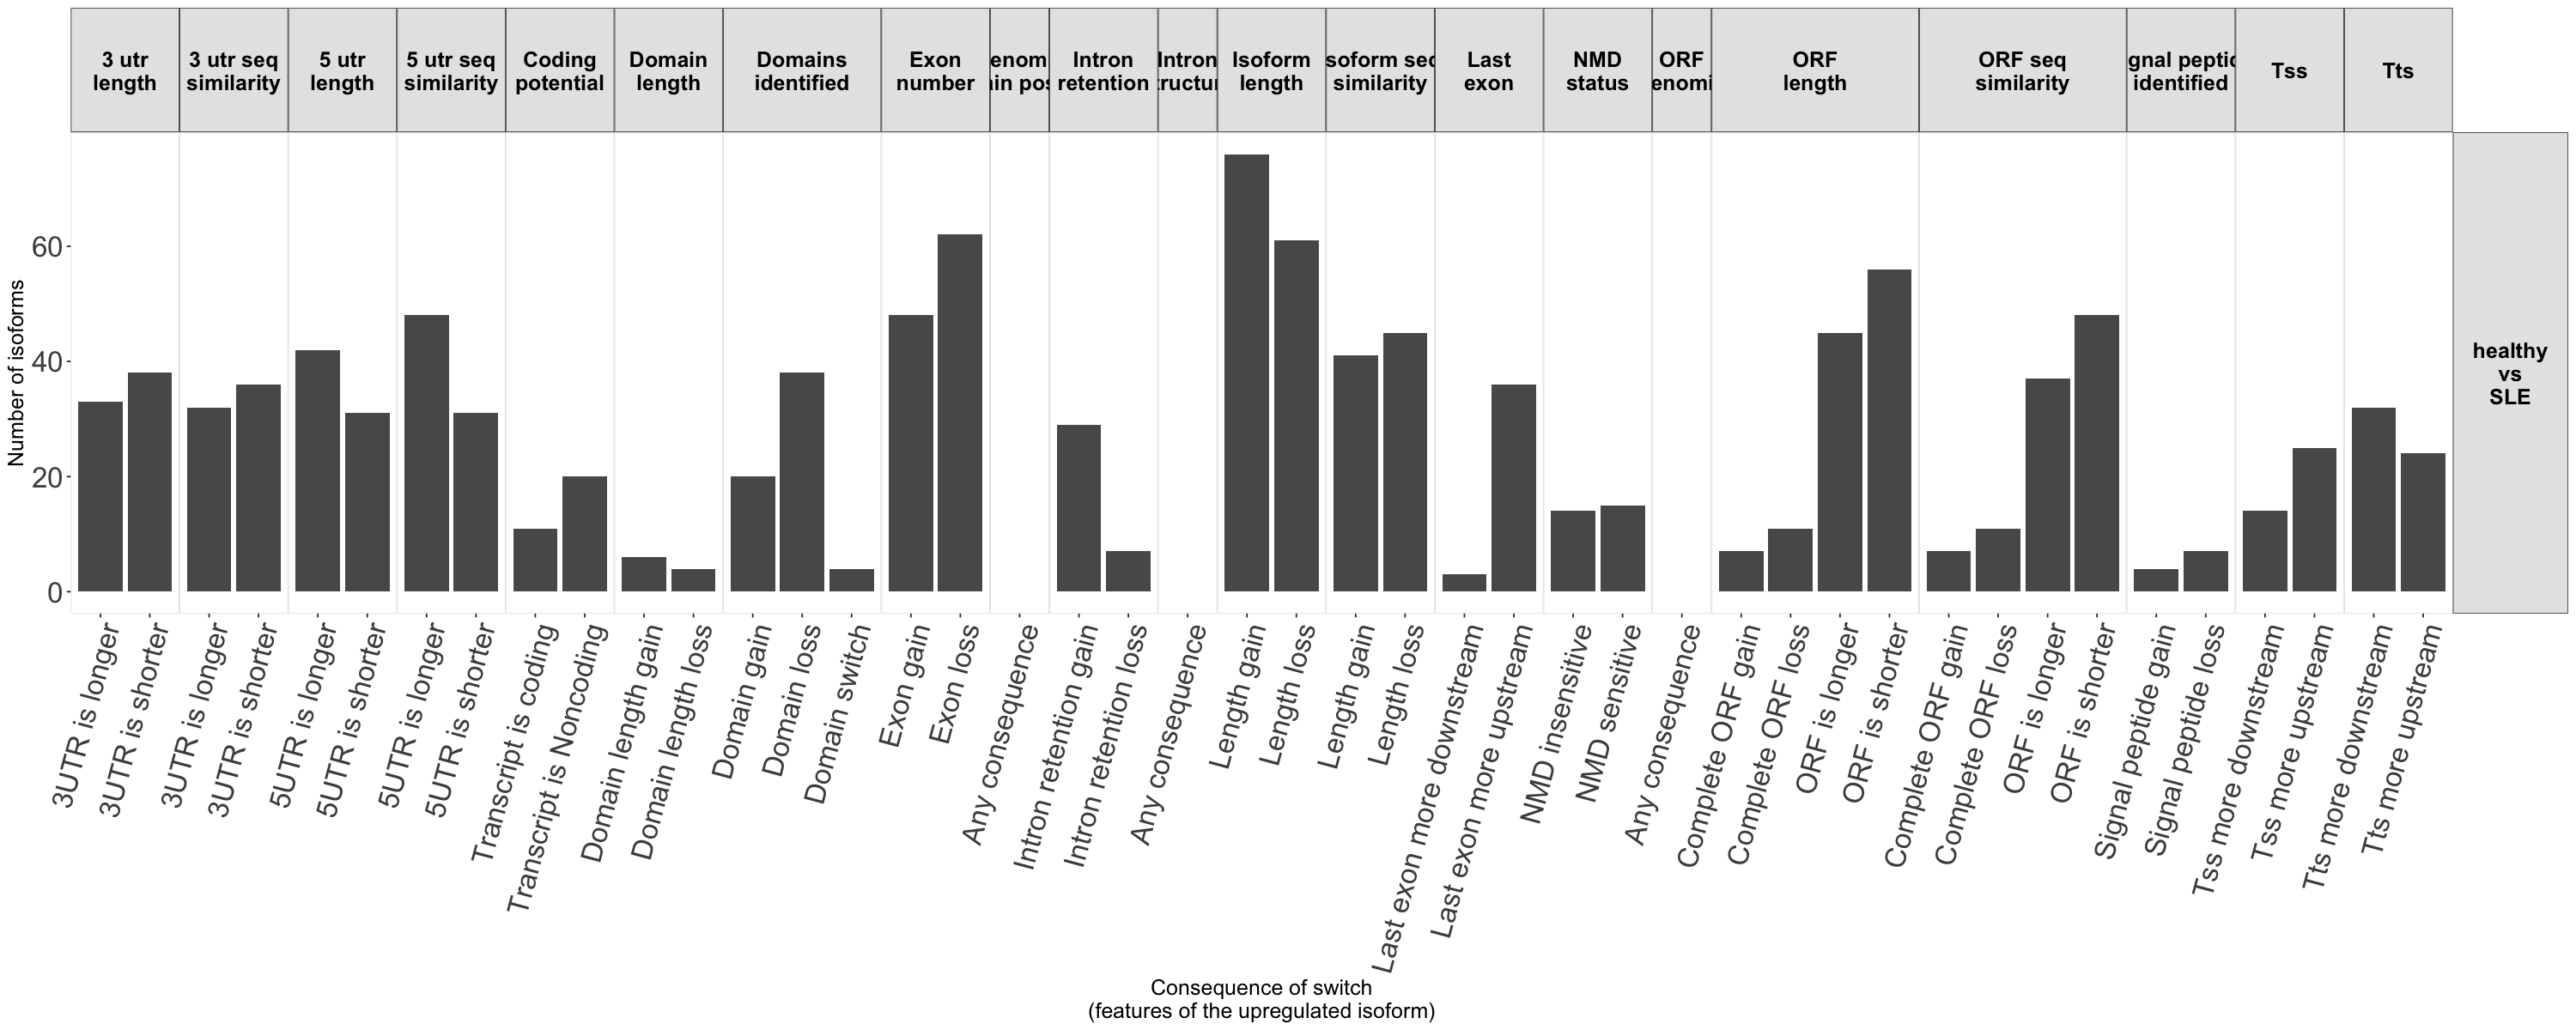

In [30]:
options(repr.plot.width=25, repr.plot.height=10)
extractConsequenceSummary(
      exampleSwitchListPart2,
      consequencesToAnalyze='all',
      plotGenes = FALSE,           # enables analysis of genes (instead of isoforms)
      asFractionTotal = FALSE      # enables analysis of fraction of significant features
    ) + 
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=20),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 20),
          axis.text.x = element_text(size = 20, angle = 75, hjust = 1),
          legend.text =  element_text(size = 20), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

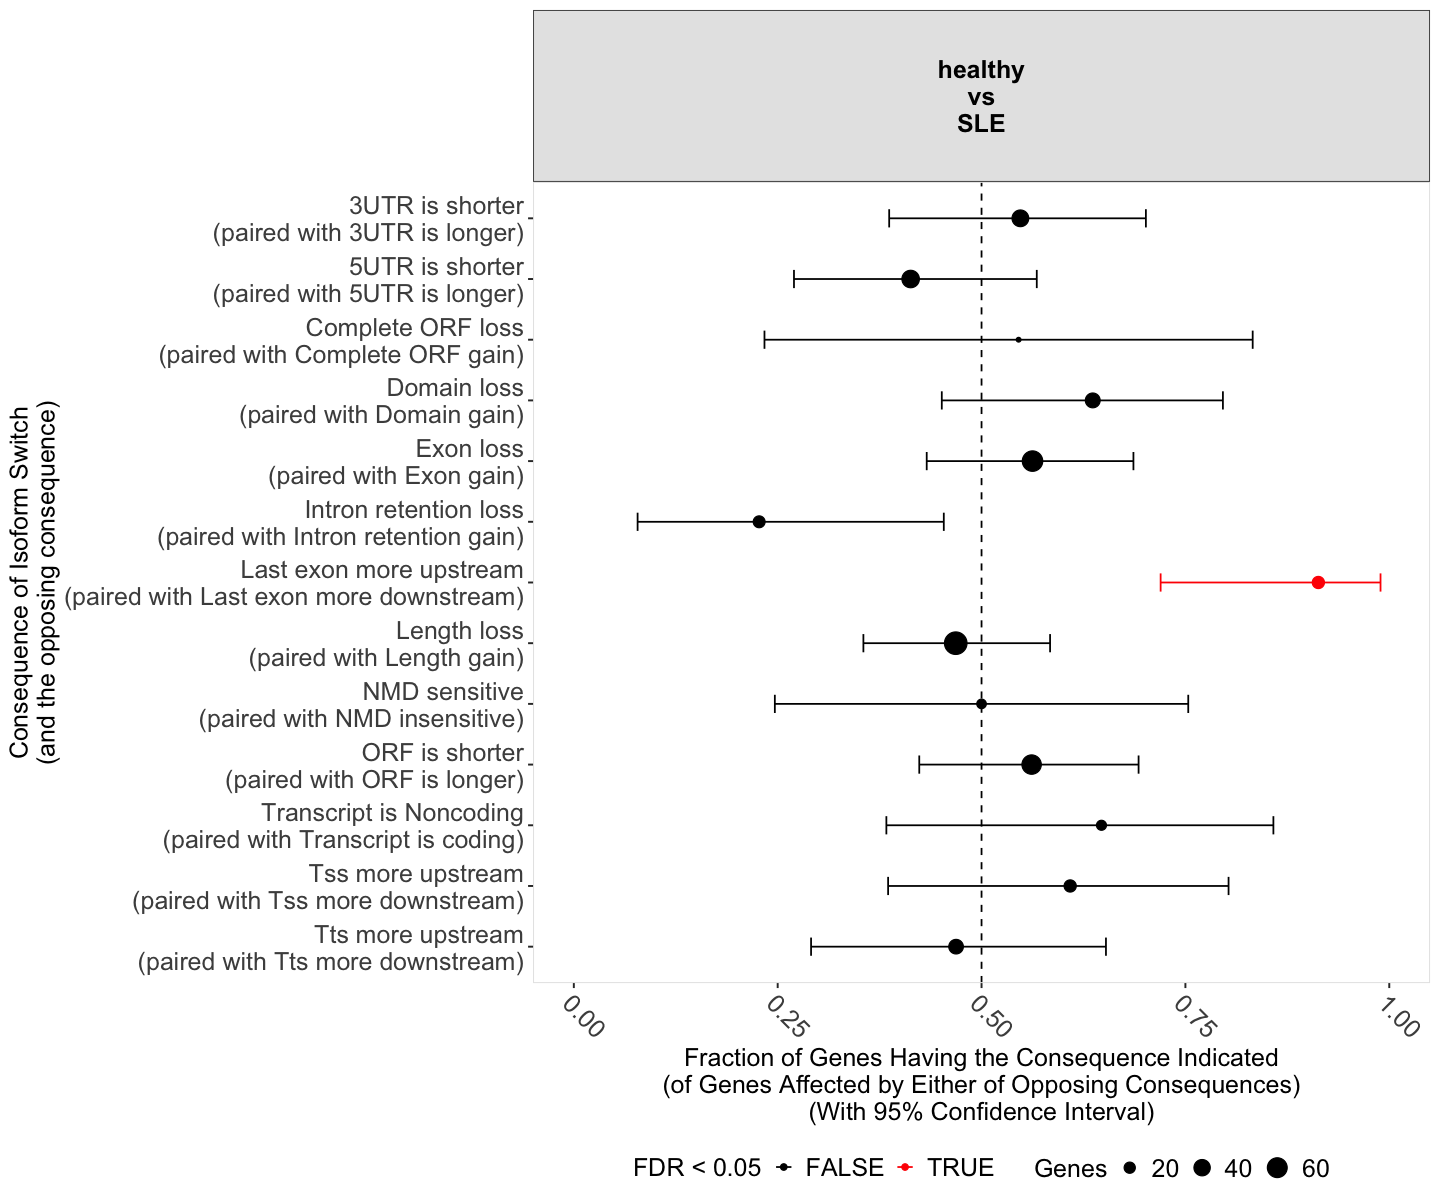

In [51]:
options(repr.plot.width=12, repr.plot.height=10)
extractConsequenceEnrichment(
      exampleSwitchListPart2,
      consequencesToAnalyze='all',
      analysisOppositeConsequence = TRUE,
      returnResult = FALSE
    ) + 
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

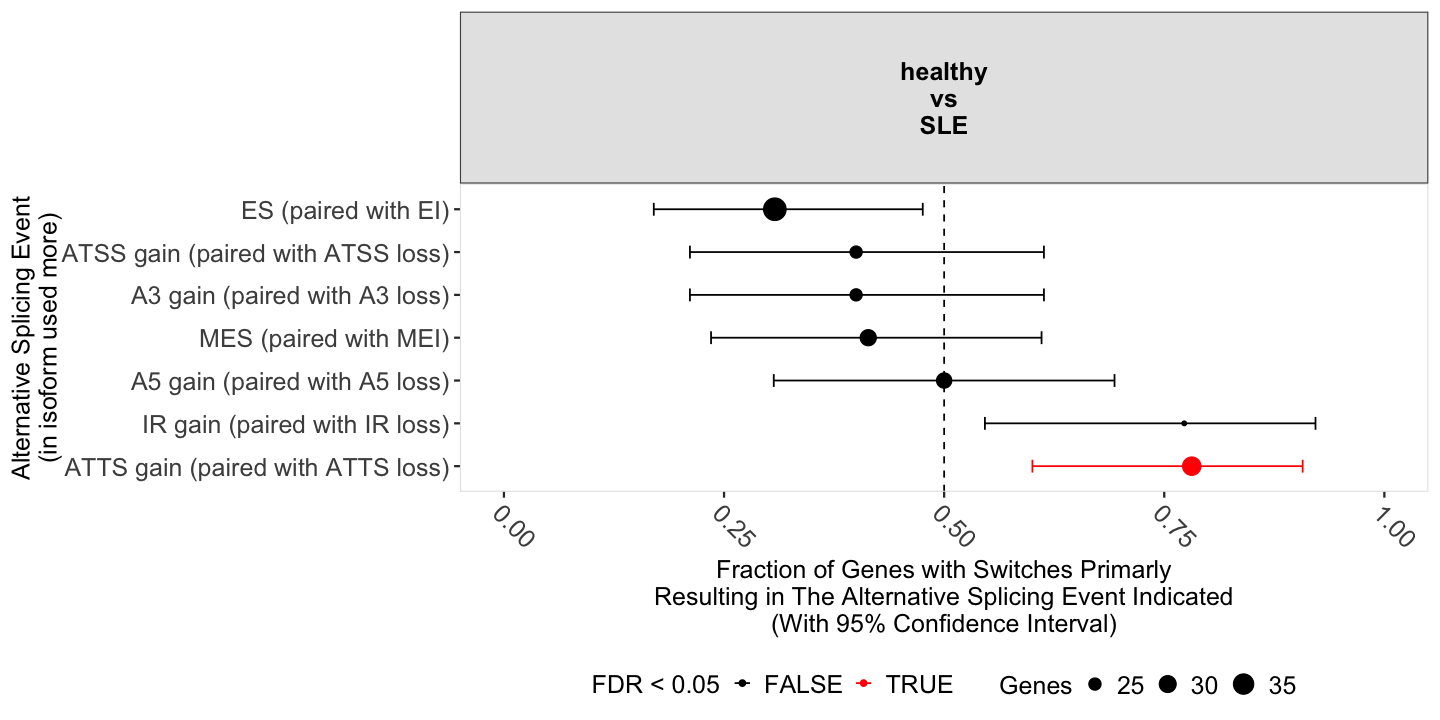

In [53]:
options(repr.plot.width=12, repr.plot.height=6)
extractSplicingEnrichment(
      exampleSwitchListPart2,
      returnResult = FALSE
    ) + 
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

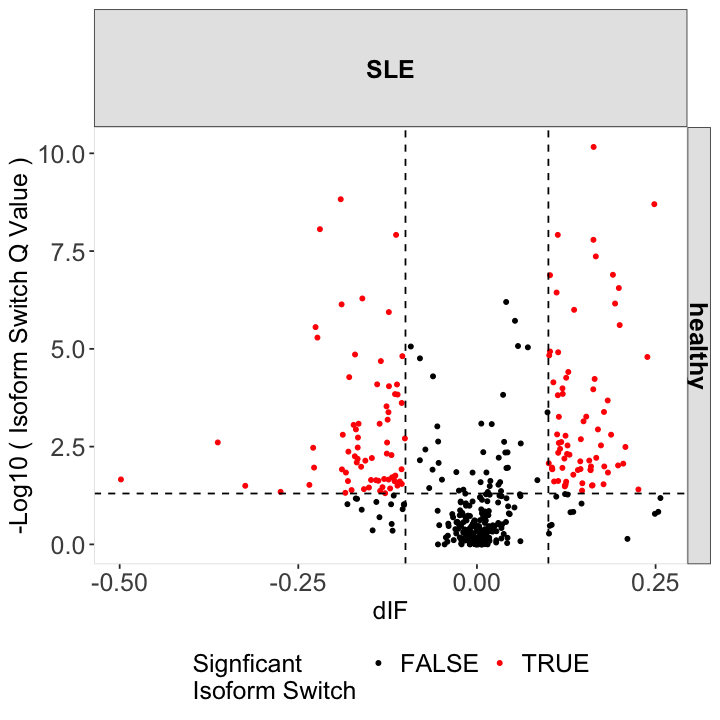

In [33]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data=exampleSwitchListPart2$isoformFeatures, aes(x=dIF, y=-log10(isoform_switch_q_value))) +
      geom_point(
        aes( color=abs(dIF) > 0.1 & isoform_switch_q_value < 0.05 ), # default cutoff
        size=1
      ) +
      geom_hline(yintercept = -log10(0.05), linetype='dashed') + # default cutoff
      geom_vline(xintercept = c(-0.1, 0.1), linetype='dashed') + # default cutoff
      #facet_wrap( ~ condition_2) +
      facet_grid(condition_1 ~ condition_2) + # alternative to facet_wrap if you have overlapping conditions
      scale_color_manual('Signficant\nIsoform Switch', values = c('black','red')) +
      labs(x='dIF', y='-Log10 ( Isoform Switch Q Value )') +
      theme_bw() + 
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

In [ ]:
gene = "IRAK1"

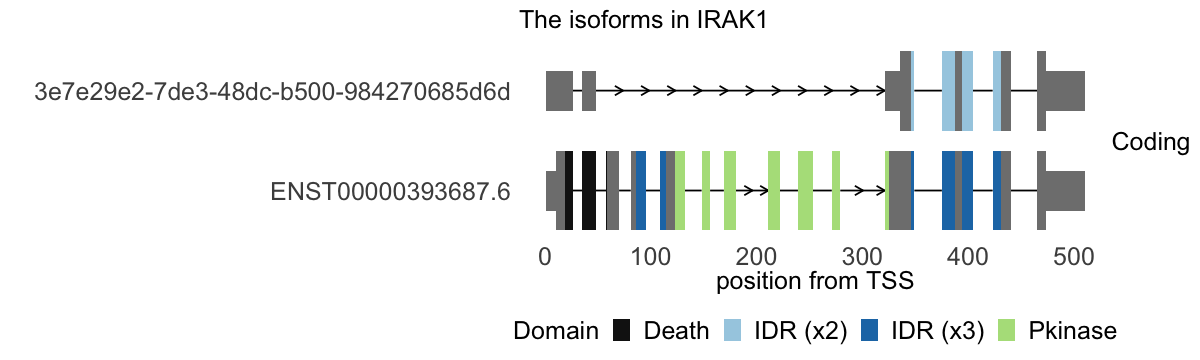

In [49]:
options(repr.plot.width=10, repr.plot.height=3)
switchPlotTranscript(
        exampleSwitchListPart2,
        isoform_id = intersect(c(exampleSwitchListPart2@.Data[[18]] %>%
                                   # dplyr::filter(!is.na(switchConsequence)) %>%
                                   dplyr::filter(gene_id == gene) %>%
                                   .$isoformUpregulated,
                                 exampleSwitchListPart2@.Data[[18]] %>%
                                   # dplyr::filter(!is.na(switchConsequence)) %>%
                                   dplyr::filter(gene_id == gene) %>%
                                   .$isoformDownregulated) %>%
                                 unique(),
                               exampleSwitchListPart2$orfAnalysis$isoform_id)
      ) + 
    xlab("position from TSS") +
    theme(strip.text.x=element_text(size=15, color="black", margin = margin(1,0,1,0, "cm")),
          strip.text.y=element_text(size=15, color="black", margin = margin(1,0,1,0, "cm")),
          strip.background=element_rect(color="white", fill="white"),
          panel.border=element_rect(color="white"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =0),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



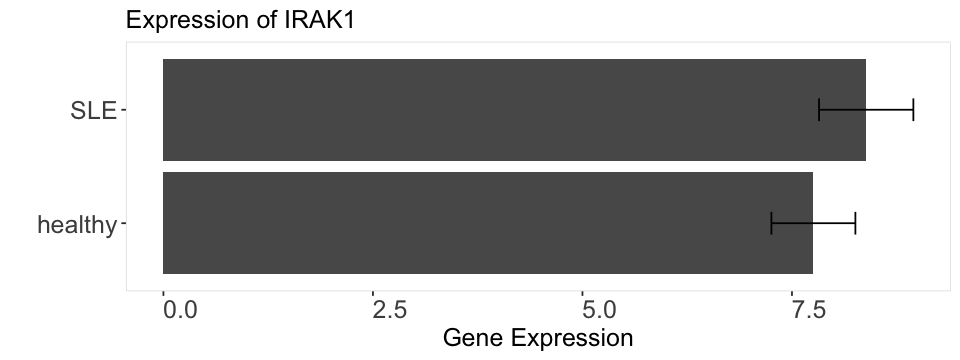

In [85]:
options(repr.plot.width=8, repr.plot.height=3)
switchPlotGeneExp(
        exampleSwitchListPart2,
        gene = gene
      ) +
    xlab("")+
    coord_flip() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0,1,0, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size = 15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 0),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



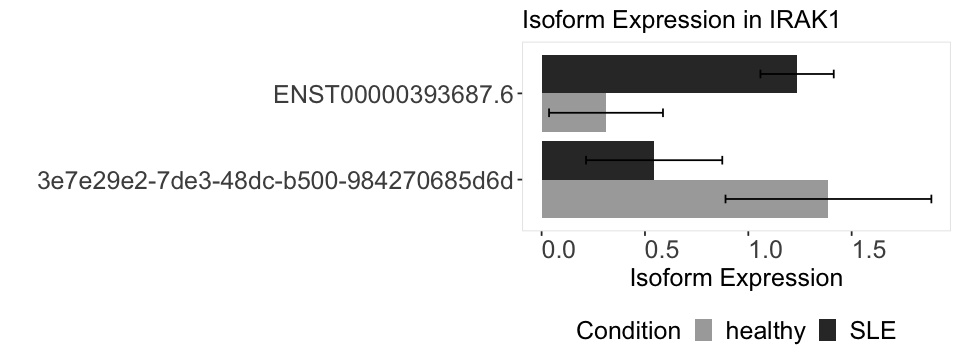

In [90]:
options(repr.plot.width=8, repr.plot.height=3)
switchPlotIsoExp(
        exampleSwitchListPart2,
        isoform_id = intersect(c(exampleSwitchListPart2@.Data[[18]] %>%
                                   # dplyr::filter(!is.na(switchConsequence)) %>%
                                   dplyr::filter(gene_id == gene) %>%
                                   .$isoformUpregulated,
                                 exampleSwitchListPart2@.Data[[18]] %>%
                                   # dplyr::filter(!is.na(switchConsequence)) %>%
                                   dplyr::filter(gene_id == gene) %>%
                                   .$isoformDownregulated) %>%
                                 unique(),
                               exampleSwitchListPart2$orfAnalysis$isoform_id)
      ) + 
    xlab("")+
    coord_flip() +
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 0),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))

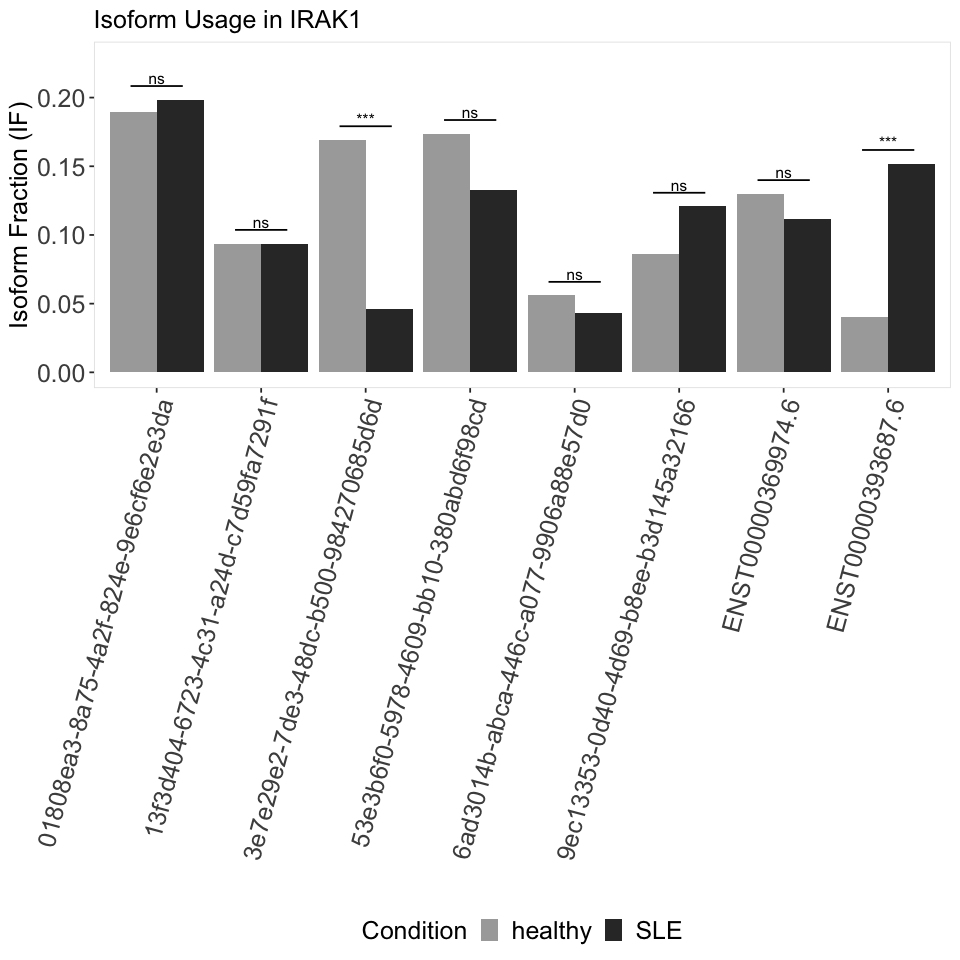

In [108]:
options(repr.plot.width=8, repr.plot.height=8)
switchPlotIsoUsage(
        exampleSwitchListPart2,
        gene = gene,
        condition1 = condition1,
        condition2 = condition2
      ) +
    xlab("")+
    theme(strip.text.x=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.text.y=element_text(size=15, color="black", face="bold",margin = margin(1,0.5,1,0.5, "cm")),
          strip.background=element_rect(color="grey30", fill="grey90"),
          panel.border=element_rect(color="grey90"),
          panel.grid=element_blank(),
          panel.spacing=unit(0,"lines"),
          legend.position = "bottom",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15, angle = 75, hjust = 1),
          legend.text =  element_text(size = 15), 
          legend.key.size = grid::unit(0.8, "lines"),
          legend.title = element_text(size = 15, hjust = 0))